What the notebook does:
<ul>
<li>Reads shp file in WGS84</li>
<li>Takes in lising samples[10k]</li> 
<li>Identifies which subzone a listing belongs to.</li>
</ul>
<H3>Contains implementation for membership testing</H3>
<i>Takes 240ms to identify membership for a single point. Need to improve.

In [13]:
import fiona
from mpl_toolkits.basemap import Basemap
import SVY21
from itertools import chain
import pandas as pd
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from shapely.prepared import prep
import numpy as np
import copy
import numba
from numba import jit
import time
import random
%matplotlib inline

In [2]:
listing = pd.read_csv("LISTINGS_2014_2015.csv")

/home/vagrant/miniconda3/envs/gurulabs/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (33,67) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [17]:
listing_df = listing[["id","property_name","type_code","available_date","price","bedrooms","floorarea","longitude","latitude","postcode","area_code","district_code","property_type_code"]]
listing_df=listing_df.sample(10000)

In [18]:
listing_df = listing_df.dropna()

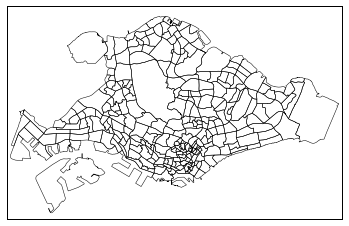

In [19]:
shp = fiona.open("subzone//Subzone_Census2010WGS84.shp")
bds = shp.bounds
shp.close()
cv = SVY21.SVY21()

extra = 0.01
ll = (bds[0],bds[1])
ur = (bds[2],bds[3])
coords = list(chain(ll,ur))
w,h = coords[2]-coords[0],coords[3]-coords[1]

m = Basemap(
    projection = 'tmerc',
    lon_0=103.49,
    lat_0=1.21,
    ellps='WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='h',
    suppress_ticks=True)

m.readshapefile(
    "subzone//Subzone_Census2010WGS84",
    "subzone",
    color=None,
    ax=None,
    drawbounds=True
    )

def location2subzone(lon,lat,m):
    p = Point(m(lon,lat))
    df_map = pd.DataFrame({
        'subzone_name':[ward['SUBZONE_N'] for ward in m.subzone_info],
        'poly':[prep(Polygon(xy)) for xy in m.subzone]})
    #p=df_map["poly"][52].representative_point()
    for i,r in df_map.iterrows():
        if r["poly"].contains(p):
            return r["subzone_name"]
    return "No mapping found"

@jit
def location2subzone_jit(lon,lat):
    global m
    points = zip(lon,lat)
    subzones = []
    for x,y in points:
        subzones.append(location2subzone(x,y,m))
    return subzones

In [ ]:
location2subzone(103.775798,1.292941,m)

In [20]:
start = time.clock()
listing_df["subzones"] = [location2subzone(r["longitude"],r["latitude"],m) for i,r in listing_df.iterrows()]
print time.clock()-start

2414.23


In [27]:
listing_df["district_code"].unique()

array(['D19', 'D16', 'D10', 'D07', 'D09', 'D18', 'D27', 'D23', 'D25',
       'D02', 'D22', 'D04', 'D28', 'D15', 'D11', 'D03', 'D20', 'D05',
       'D21', 'D12', 'D08', 'D01', 'D14', 'D17', 'D26', 'D13'], dtype=object)

In [22]:
listing_df.to_csv("Listing_wSubzone.csv",index=False)

In [28]:
listing_df.head(1)

,id,property_name,type_code,available_date,price,bedrooms,floorarea,longitude,latitude,postcode,area_code,district_code,property_type_code,subzones
12270,18513220,Cherryhill,RENT,2014-11-01 10:35:20,3500,3,1550,103.878075,1.350561,536471,53,D19,CONDO,SERANGOON CENTRAL


In [51]:
district_map = pd.read_csv("district_map.csv")
district_map = district_map[["district_code","district_description"]]

In [53]:
listing_wdist = pd.merge(left=listing_df,right=district_map,left_on="district_code",right_on="district_code")

In [54]:
listing_wdist.head(2)

,id,property_name,type_code,available_date,price,bedrooms,floorarea,longitude,latitude,postcode,area_code,district_code,property_type_code,subzones,district_description
0,18513220,Cherryhill,RENT,2014-11-01 10:35:20,3500,3,1550,103.878075,1.350561,536471,53,D19,CONDO,SERANGOON CENTRAL,Hougang / Punggol / Sengkang
1,18877230,The Quartz,SALE,2015-03-13 14:52:56,1320000,3,1195,103.894377,1.381178,544984,54,D19,CONDO,TRAFALGAR,Hougang / Punggol / Sengkang


In [56]:
listing_wdist.to_csv("Listing_wSubzone.csv",index=False)

In [60]:
listing_wdist["district_code"].unique()

array(['D19', 'D16', 'D10', 'D07', 'D09', 'D18', 'D27', 'D23', 'D25',
       'D02', 'D22', 'D04', 'D28', 'D15', 'D11', 'D03', 'D20', 'D05',
       'D21', 'D12', 'D08', 'D01', 'D14', 'D17', 'D26', 'D13'], dtype=object)